In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
from simulation_utils import run_my_lin, run_std_approach
from DataGenerator import DataGenerator
from constants_sim import RANDOM_SEED, PARAMS, IL_COLOR

In [2]:
RANDOM_SEED = 43
PARAMS["method"] = "gaussian"
PARAMS["deducted_frac"] = 0

dg = DataGenerator(random_seed=RANDOM_SEED)

fig_name = f'eff_of_corr_{PARAMS["n_common"]}common_{PARAMS["noise"]}noise_{PARAMS["n_informative"]}_\
informative_res_coef{PARAMS["res_coef_value"]}_gt_coef{PARAMS["gt_coef_value"]}'
fig_save_path = f'../../../sent/simulated/leave_out/figure/{fig_name}.png'

In [3]:
X_train, y_train, X_test, y_test, y_test_no_coi, res_proportion, coefs, res_coefs = dg.generate_linear_data(**PARAMS)

#### Select predictors (i.e., model knowledge)

In [5]:
vars = [str(x) for x in list(range(0, PARAMS['n_informative']*3))]
gt_vars = [] #vars[:int(params['n_informative']/2)]
res_vars =  vars[-int(PARAMS['n_informative']):] # drop all predictors of COI
drop_vars = gt_vars + res_vars

frac_deducts = np.linspace(0, 1, 5)

our_results = []
std_results = []
res_proportions = []
corrs = []
for fraction in frac_deducts:
    PARAMS['deducted_frac'] = fraction
    corrs.append((0.999999 / PARAMS['n_informative']) * (1 - fraction))
    X_train, y_train, X_test, y_test, y_test_no_coi, res_proportion, coefs, res_coefs = dg.generate_linear_data(**PARAMS)
    X_train.drop(drop_vars, axis=1, inplace=True)
    X_test.drop(drop_vars, axis=1, inplace=True)
    # run std appraoch
    std_results.append(run_std_approach(X_train, y_train, X_test, y_test))
    # run our approach
    our_results.append(run_my_lin(X_train, X_test, y_train, y_test))
    # save res_proportions
    res_proportions.append(res_proportion)

/Users/cbirkenbihl/git/Cog_resilience/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
pickle.dump((std_results, our_results, res_proportions, corrs), open(f'../../../sent/simulated/leave_out/pickles/{fig_name}.p', 'wb'))

In [4]:
std_results, our_results, res_proportions, corrs = pickle.load(open(f'../../../sent/simulated/leave_out/pickles/{fig_name}.p', 'rb'))

ValueError: not enough values to unpack (expected 4, got 3)

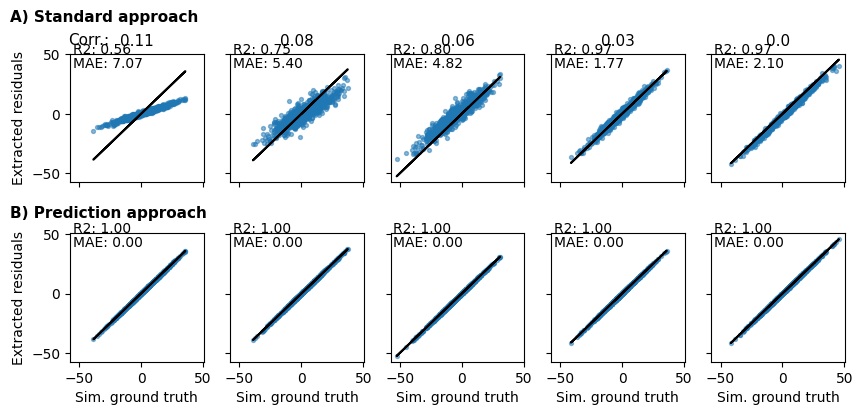

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)
# plt.suptitle("Simulation results for linear assumption on gt and resilience", fontsize=14, y=0.94)

for (results_std_app, r2gt), corr, res_proportion, ax in zip(std_results, corrs, res_proportions, axes.flatten()):
    ax.set_title(f"{np.round(corr, 2)}", fontsize=11)
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"MAE: {mean_absolute_error(res_proportion, results_std_app['Residual']):.2f}", 
                    ha='left', va='top', transform=ax.transAxes)
    plt.text(.02, .98, f"R2: {r2_score(res_proportion, results_std_app['Residual']):.2f}", 
                    ha='left', va='bottom', transform=ax.transAxes)

for (results_our_app, r2gt), res_proportion, ax in zip(our_results, res_proportions, axes.flatten()[len(frac_deducts):]):
    ax.scatter(res_proportion, results_our_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"MAE: {mean_absolute_error(res_proportion, results_our_app['Residual']):.2f}", 
                    ha='left', va='top', transform=ax.transAxes)
    plt.text(.02, .98, f"R2: {r2_score(res_proportion, results_our_app['Residual']):.2f}", 
                    ha='left', va='bottom', transform=ax.transAxes)


plt.figtext(0.123, 0.9313, "Corr.:", ha="left", va="top", fontsize=11)
plt.figtext(0.065, 0.99, "A) Standard approach", ha="left", va="top", weight='bold', fontsize=11)
plt.figtext(0.065, 0.5, "B) Prediction approach", ha="left", va="top", weight='bold', fontsize=11)
plt.subplots_adjust(hspace = 0.4)

for ax in axes[:, 0]:
    ax.set_ylabel("Extracted residuals")
for ax in axes[-1]:
    ax.set_xlabel("Sim. ground truth")

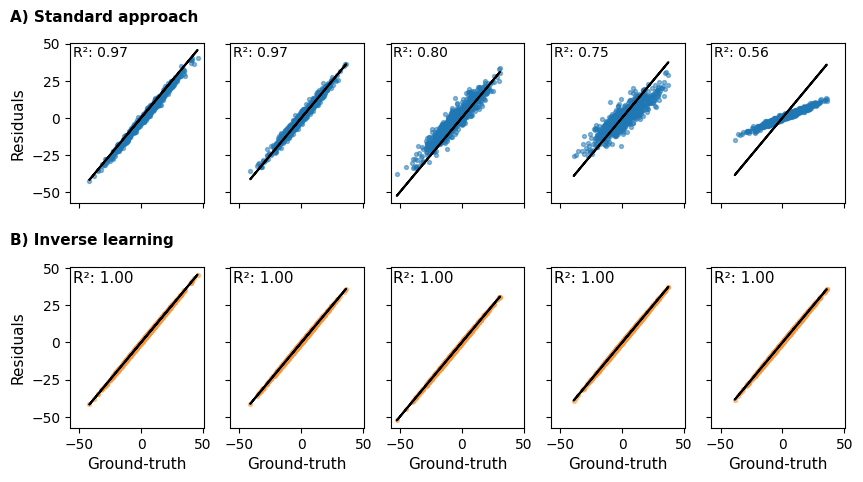

In [8]:
fontsize_mse = 11
fig, axes = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)
# plt.suptitle("Simulation results for linear assumption on gt and resilience", fontsize=14, y=0.94)

for (results_std_app, r2gt), corr, res_proportion, ax in zip(std_results[::-1], 
                                                             corrs[::-1], 
                                                             res_proportions[::-1], 
                                                             axes.flatten()):
    # ax.set_title(f"{np.round(corr, 2)}", fontsize=11)
    ax.scatter(res_proportion, results_std_app["Residual"], alpha=0.5, s=8)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"R²: {r2_score(res_proportion, results_std_app['Residual']):.2f}", 
                    ha='left', va='top', transform=ax.transAxes)

for (results_our_app, r2gt), res_proportion, ax in zip(our_results[::-1], 
                                                       res_proportions[::-1], 
                                                       axes.flatten()[len(frac_deducts):]):
    ax.scatter(res_proportion, results_our_app["Residual"], alpha=0.5, s=8, color=IL_COLOR)
    ax.plot(res_proportion, res_proportion, color='black')
    plt.text(.02, .98, f"R²: {r2_score(res_proportion, results_our_app['Residual']):.2f}", 
                    ha='left', va='top', transform=ax.transAxes, fontsize=fontsize_mse)


# plt.figtext(0.123, 0.9313, "Corr.:", ha="left", va="top", fontsize=11)
plt.figtext(0.065, 0.946, "A) Standard approach", ha="left", va="top", weight='bold', fontsize=fontsize_mse)
plt.figtext(0.065, 0.5, "B) Inverse learning", ha="left", va="top", weight='bold', fontsize=fontsize_mse)
plt.subplots_adjust(hspace = 0.4)

for ax in axes[:, 0]:
    ax.set_ylabel("Residuals", fontsize=11)
for ax in axes[-1]:
    ax.set_xlabel("Ground-truth", fontsize=11)
plt.savefig(fig_save_path, dpi=300, bbox_inches='tight')